RECORDAR DESZIPEAR PROPERATTI.ZIP

In [36]:
import pandas as pd
import numpy as np

In [37]:
data = pd.read_csv("properatti.csv", index_col=0)
data.shape

(121220, 25)

In [38]:
data.dtypes

operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
dtype: object

### Veamos el tema de los m2 faltantes

Primera cosa a tener en cuenta, los m2 covered tienen un pctje nulo del 16% y los totales tienen un pctje del 32%
Price_per_m2 tiene un faltante del 28%
Price usd per m2 tiene un faltante del 43%
Todos las variantes de precios totales tienen un faltante aprox del 17%

*JONI! te acordas a que haciamos referencia en este párrafo*

# Verificar si existen filas con todos los datos faltantes

In [39]:
df_usd_m2 = data['price_usd_per_m2']
mask_nan_uds_m2= df_usd_m2.isna()

In [40]:
mask_nan_sup_total=data["surface_total_in_m2"].isna()
mask_nan_sup_cubierta=data["surface_covered_in_m2"].isna()
mask_nan_rooms=data["rooms"].isna()


In [41]:
mask_nan_columnas = (mask_nan_sup_total == True) & (mask_nan_sup_cubierta == True) &(mask_nan_rooms == True) &(mask_nan_uds_m2 == True) 
mask_nan_columnas.value_counts()

False    113090
True       8130
dtype: int64

#Nota: volver a revisar estos datos despues de haber completado todas las columnas con los datos extraidos del campo descripcion - inicial 8130

## Columna Superficie

#### 1- detectar de outliers

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

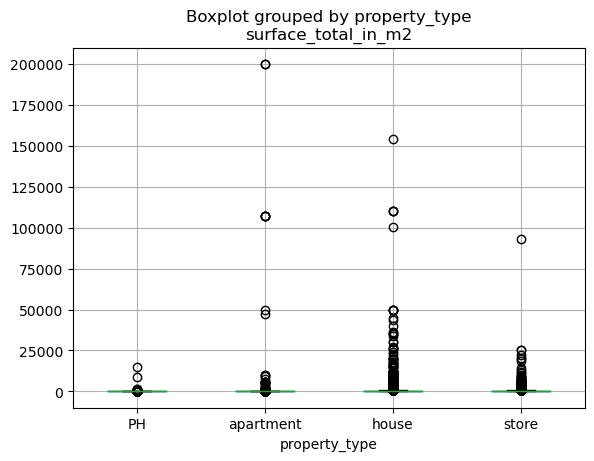

In [43]:
data.boxplot(column= "surface_total_in_m2", by="property_type") 
plt.show()

se detectan outliers para superficies mayores a 75000 m2.

##### VER SI ELIMINAMOS OUTLIERS!!!!

#### 2-Recuperar informacion faltante a través de regex de la columna descripción

In [44]:
import re

In [45]:
serie_descripcion = data["description"]

In [46]:
pattern_sup_m2 = "(?P<sup>\d{2,}(,|.\d+)?)\s*(m2|metros|mts)"
pattern_sup_m2_regex = re.compile(pattern_sup_m2,  re.IGNORECASE)

In [47]:
import numpy as np
sup_match = serie_descripcion.apply(lambda x: x if x is np.NaN else pattern_sup_m2_regex.search(x))


In [48]:
sup_match.sample(10)

28815       <re.Match object; span=(0, 7), match='130 mts'>
69082                                                  None
52572     <re.Match object; span=(143, 152), match='15 m...
17608                                                  None
26876     <re.Match object; span=(112, 117), match='38MTS'>
103454                                                 None
13970     <re.Match object; span=(148, 154), match='50 m...
14812                                                  None
83569                                                  None
103729    <re.Match object; span=(451, 456), match='40 m2'>
Name: description, dtype: object

In [49]:
mask_sup_match_notnull= sup_match.notnull()

data.loc[mask_sup_match_notnull, "Sup_m2_Clean"] = sup_match[mask_sup_match_notnull].apply(lambda x: x.group("sup"))


In [50]:
#data.loc[mask_sup_match_notnull, ["surface_total_in_m2", "surface_covered_in_m2", "Sup_m2_Clean"]]----para borrar

,surface_total_in_m2,surface_covered_in_m2,Sup_m2_Clean
6,106.0,78.0,106
10,1514.0,NaN,1514
13,50.0,30.0,30
14,42.0,31.0,30
18,270.0,270.0,40
...,...,...,...
121208,NaN,178.0,210
121210,NaN,120.0,50
121216,360.0,360.0,572
121217,46.0,39.0,"43,00"


In [51]:
serie_sup_m2_clean=data["Sup_m2_Clean"]

In [68]:
print(serie_sup_m2_clean.notnull().sum())
serie_sup_m2_clean.isnull().sum()

40087


81133

In [144]:
#SE ARREGLAN ERRORES DE COLUMNA DE REGEX PARA PODER SER UTILIZADOS EN ESTADISTICA

pattern_sup_m2_dos="(?P<supdos>\d{2,})"
pattern_sup_m2_regex_dos=re.compile(pattern_sup_m2_dos)
sup_match_dos = serie_sup_m2_clean.apply(lambda x: x if x is np.NaN else pattern_sup_m2_regex_dos.search(x))
mask_sup_match_notnull_dos= sup_match_dos.notnull()
data.loc[mask_sup_match_notnull_dos, "Sup_m2_Clean_dos"] = sup_match_dos[mask_sup_match_notnull_dos].apply(lambda x: x.group("supdos"))
data["Sup_m2_Clean_dos"].median()


TypeError: expected string or bytes-like object

##### Se supone que para PH, apartments y store la superficie cubierta es la misma que la superficie total, *se descarta house entendiendo que estas pueden contar con "patio". con estos datos se reemplazan los valores faltantes(no lo pude separar -VER!!!!*. PASAR PARA ARRIBA para dar orden al analisis

In [ ]:
data_limpia= data


In [ ]:
data_limpia["sup_m2_total_limpia"] = data_limpia["surface_total_in_m2"]

In [ ]:
data_key_not_null_mask = np.logical_and(data.property_type.notnull(), data.surface_covered_in_m2.notnull())
data_key_not_null = data.loc[data_key_not_null_mask, :]
data_key_not_null.shape

In [ ]:
data_key_not_null_grouped_tipo_sup= data_key_not_null.groupby(["property_type", "surface_covered_in_m2"])


In [ ]:
data_fillna= data_key_not_null_grouped_tipo_sup["surface_total_in_m2"].transform(lambda grp: grp.fillna(grp.mean()))
data_fillna

In [ ]:
data_limpia["sup_m2_total_limpia"].fillna(data_fillna,inplace=True)
#data_limpia.loc[mask_sup_match_notnull, ["surface_total_in_m2", "sup_m2_total_limpia", "property_type"]]

In [ ]:
data_limpia["sup_m2_total_limpia"].isnull().sum()

### se adicionan los datos obtenidos de la columna descripcion.

In [ ]:
data_limpia["sup_m2_total_limpia"].fillna(data_limpia["Sup_m2_Clean_dos"],inplace=True)

In [ ]:
data_limpia["sup_m2_total_limpia"].isnull().sum()/data["surface_total_in_m2"].isnull().sum()*100

### se recupera el 23% de la informacion faltante al suponer superficie cubierta como superficie total y al extraer informacion con metodo regex de la columna descripción 


In [ ]:
data_limpia["sup_m2_total_limpia"].isnull().sum()/data_limpia.shape[0]*100

#### se redujo de 17% a 7.6% la información faltante.

# Para los datos faltantes en la columna de interés, se desea agrupar por tipo de propiedad para sacar la mediana de los m2 totales y estratificar los valores. de esta manera podriamos tener los datos completos. REVISAR SI ES NECESARIO

# Columna Rooms

### Revisar relacion precio vs rooms. comparar propiedades similares con distinta cantidad de rooms para ver si varia sustancialmente el precio - PENDIENTE

In [100]:
## Arranco por los monoambientes
#pattern_mono='(?P<sup>\d{2,}(,|.\d+)?)\s*(mono)\S+?'
pattern_mono='(mono)|(mono\s+\w+)|(mono\.+\w+)|(mono\-+\w+)|(mono\w+)'
pattern_mono_regex=re.compile(pattern_mono,re.IGNORECASE)

In [101]:
serie_mono_descripcion=data['description']
mono_match = serie_mono_descripcion.apply(lambda x: x if x is np.NaN else pattern_mono_regex.search(x))
#sup_match = serie_descripcion.apply(lambda x: x if x is np.NaN else pattern_sup_m2_regex.search(x))


In [102]:
mask_mono_match=mono_match.notnull()
col_mono_prueba_nulos=mono_match[mask_mono_match]
col_mono_prueba_nulos.shape

(10749,)

In [106]:
data.loc[mask_mono_match,'Ambientes_Clean']= 1

#### Ahora me enfoco en todos los departamentos que no sean monos, uso por ahora ambientes, para evitar confusiones con dormitorios y habitaciones

In [129]:
#pattern_rooms= "(?P<dorm>\d+.?Dorm|\d+.?dorm|\d+.?DORM|\d+.?AMB|\d+.?Amb|\d+.?amb|\d+.?hab|\d+.?HAB|\d+.?Hab|monoamb)"
#pattern_rooms= "(?P<dorm>\d{2,}(,|.\d+)?)\s*(Dorm|amb|monoamb).?Dorm|\d+.?dorm|\d+.?DORM|\d+.?AMB|\d+.?Amb|\d+.?amb|\d+.?hab|\d+.?HAB|\d+.?Hab|monoamb)"
#"(?P<sup>\d{2,}(,|.\d+)?)\s*(m2|metros|mts)"(mono)|(mono\s+\w+)|(mono\.+\w+)|(mono\-+\w+)|(mono\w+)
#"(?P<sup>\d{2,}(,|.\d+)?)\s*(m2|metros|mts)"
pattern_ambs="(?P<num>\d)\s*(\samb\w*\s)"
pattern_ambs_regex=re.compile(pattern_ambs,re.IGNORECASE)

In [132]:
mask_mono_nulo=mono_match.isnull()
col_mono_nulo=mono_match[mask_mono_nulo]
pattern_ambs_match=serie_descripcion.apply(lambda x: x if x is np.NaN else pattern_ambs_regex.search(x))

In [143]:
type(pattern_ambs_match)

pandas.core.series.Series

In [142]:
#data.loc[mask_mono_nulo, "Ambientes_Clean"] = pattern_ambs_match[mask_mono_nulo].apply(lambda x: x.group(0))
pattern_ambs_match_2=pattern_ambs_match.apply(lambda x: x[0])

TypeError: 'NoneType' object is not subscriptable

In [ ]:
pattern_rooms_regex=re.compile(pattern_rooms)

In [ ]:
room_match = serie_descripcion.apply(lambda x: x if x is np.NaN else pattern_rooms_regex.search(x))

In [ ]:
room_match.sample(10)

In [ ]:
mask_rooms_notnull= room_match.notnull()

data.loc[mask_rooms_notnull, "rooms_clean"] = room_match[mask_rooms_notnull].apply(lambda x: x.group(0))


In [ ]:
serie_rooms_clean=data["rooms_clean"]
serie_rooms_clean.sample(5)


### se saca la parte entera del str

In [ ]:
pattern_rooms_dos="(?P<dorm_dos>\d+.?)"
pattern_rooms_regex_dos=re.compile(pattern_rooms_dos)
room_match_dos = serie_rooms_clean.apply(lambda x: x if x is np.NaN else pattern_rooms_regex_dos.search(x))
room_match_dos.sample(10)

In [ ]:
mask_room_match_notnull_dos= room_match_dos.notnull()

data.loc[mask_room_match_notnull_dos,"rooms_clean_dos"] = room_match_dos[mask_room_match_notnull_dos].apply(lambda x: x.group(0))

In [ ]:
data.loc[mask_room_match_notnull_dos, ["rooms", "rooms_clean_dos"]]

In [ ]:
data_limpia["rooms"].fillna(data_limpia["rooms_clean_dos"],inplace=True)
data_limpia

% de info recuperada = 46%

In [ ]:
data_limpia["rooms"].isnull().sum()/data["rooms"].isnull().sum()*100

In [ ]:
mask_residencial= data.property_type != 'store'
tipos_residenciales=data.property_type[mask_residencial]
rooms_residenciales=data.rooms[mask_residencial]
df_residencial=pd.DataFrame(tipos_residenciales)
df_residencial['rooms']=rooms_residenciales

##### Intentamos ver si los datos faltantes de rooms disminuyen si descontamos las tiendas

In [ ]:
data.rooms.value_counts()

In [ ]:
shape_df=df_residencial.shape
count_res=shape_df[0]


In [ ]:
nulos_room=df_residencial.rooms.isna().sum(axis=0)
pctje_nulos_rooms=nulos_room/count_res
pctje_nulos_rooms

Veamos cuantas rooms tienen las tiendas

In [ ]:
mask_comercial= data.property_type == 'store'
tipos_comerciales=data.property_type[mask_comercial]
rooms_comerciales=data.rooms[mask_comercial]
df_comercial=pd.DataFrame(tipos_comerciales)
df_comercial['rooms']=rooms_comerciales
df_comercial.rooms.value_counts()

#### Recordemos que el porcentaje original de nulos era similar, 

Veamos si los faltantes de expensas disminuyen sacando tiendas y casas

In [ ]:
mascara_sin_casas=df_residencial.property_type !='house'
expensas_residenciales=data.expenses[mask_residencial]
df_residencial['expenses']=expensas_residenciales
expensas_deps_ph=expensas_residenciales[mascara_sin_casas]
null_exp_clean=expensas_deps_ph.isnull().sum()
shape_exp_clean=expensas_deps_ph.shape
pctje_null_exp_clean=null_exp_clean/shape_exp_clean[0]
pctje_null_exp_clean
type_deps_ph=df_residencial.property_type[mascara_sin_casas]
type_deps_ph.value_counts()

In [ ]:
expensas_deps_ph.isnull().sum()/expensas_deps_ph.shape[0]

Probemos ahora sacando los nulos de rooms para tratar de aplicar un promedio del tamaño de las rooms

In [ ]:
mask_rooms_no_nulas=data.rooms.notnull()
rooms_no_nulas=data.rooms.loc[mask_rooms_no_nulas]
sf_room_no_nulas=data.surface_covered_in_m2.loc[mask_rooms_no_nulas]
df_rooms_clean=pd.DataFrame(rooms_no_nulas)
df_rooms_clean['m2_covered']=sf_room_no_nulas
mask_rooms_no_nulas.value_counts()

In [ ]:
m2_nulos_rooms_clean=df_rooms_clean.m2_covered.isnull().sum()
shape_rooms_clean=df_rooms_clean.shape
pctje_nulos_rooms_clean=m2_nulos_rooms_clean/shape_rooms_clean[0]
pctje_nulos_rooms_clean

El pctje de m2 cubiertos es ligeramente menor, por lo que no hay mucha correlacion entre nulidad de rooms y nulidad de m2_covered
Hay que inputar los m2 cubiertos faltantes antes de poder avanzar a tener un promedio de cuantos m2 tiene cada habitación
Para imputar las rooms, me imagino hay que inputar promedio por tipo de propiedad, hace falta por barrio, o alguna caracteristica extra?? Para mi no hace falta

# Recuperar datos de precio total en dolares

### Nos centramos en este campo, por dos motivos. Sabiendo que la finalidad de esta limpieza es lograr obtener una base de datos con valores que me permitan luego armar un modelo que me ayude a determinar el valor de una propiedad, entendemos que el campo precio es el mas importante. Uno de los motivos por el cual nos centramos en el precio en dolares, es porque este campo no se ve influenciado por la inflación, por otro lado contamos con bastantes datos en la columna lo cual disminuye el error por supuestos o calculos mal hechos.

### 1-Extraer información con regex de columna descripción

In [ ]:
import re
serie_descripcion = data["description"]

pattern_usd = "(?P<usd>(usd|u[$]d)\s*?(\d{2,}(,|.\d+)?))"
pattern_usd_regex = re.compile(pattern_usd,  re.IGNORECASE)

import numpy as np
usd_match = serie_descripcion.apply(lambda x: x if x is np.NaN else pattern_usd_regex.search(x))

mask_usd_match_notnull= usd_match.notnull()

data.loc[mask_usd_match_notnull, "usd_clean"] = usd_match[mask_usd_match_notnull].apply(lambda x: x.group(0))


In [ ]:
serie_usd_clean=data["usd_clean"]

In [ ]:
pattern_usd_dos="(?P<usddos>(\d{2,}(,|.\d+)?))"
pattern_usd_regex_dos=re.compile(pattern_usd_dos)
usd_match_dos = serie_usd_clean.apply(lambda x: x if x is np.NaN else pattern_usd_regex_dos.search(x))
mask_usd_match_notnull_dos= usd_match_dos.notnull()
data.loc[mask_usd_match_notnull_dos, "usd_clean_dos"] = usd_match_dos[mask_usd_match_notnull_dos].apply(lambda x: x.group("usddos"))


In [ ]:
data_limpia["precio_usd_limpio"]=data_limpia["price_aprox_usd"]

In [ ]:
data_limpia["precio_usd_limpio"].fillna(data_limpia["usd_clean_dos"],inplace=True)

In [ ]:
data_limpia["precio_usd_limpio"].isnull().sum()

In [ ]:
(1-data_limpia["precio_usd_limpio"].isnull().sum()/data["price_aprox_usd"].isnull().sum())*100

Se recuperó el 1.2% de la informacion de precios en dolares del campo descripcion

### 2-comprobar si las columnas precio ARS y USD pueden matchear- listo

In [ ]:
mask_ARS_empty=data["price_aprox_local_currency"].isnull()
mask_ARS_empty.value_counts()

In [ ]:
mask_USD_empty=data["price_aprox_usd"].isnull()
mask_USD_empty.value_counts()

In [ ]:
mask_precio_empty=mask_ARS_empty&mask_USD_empty
data[mask_precio_empty].shape

##### coinciden la cantidad de filas vacias en cada campo, por lo cual no es posible completar completar datos vacios de USD con ARS sacados de la columna "price_aprox_local_currency"

### 3-Determinar la variacion precio con rooms y superficie---- ver de pasar arriba

calculamos la correlacion entre variables

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df_surf_float = data["surface_total_in_m2"].astype(float) 
df_room_float = data['rooms'].astype(float) 
df_price_float = data['price_aprox_usd'].astype(float) 
df_tipo = data['property_type']

In [ ]:
data_tipo_usd_sup_room=pd.DataFrame((df_tipo,df_surf_float,df_room_float,df_price_float))
data_tipo_usd_sup_room_T=data_tipo_usd_sup_room.T
data_tipo_usd_sup_room_T.sample(10)

In [ ]:
g = sns.PairGrid(data_tipo_usd_sup_room_T, vars=['property_type','surface_total_in_m2','rooms','price_aprox_usd'],hue='property_type', palette='deep')
g.map(plt.scatter, alpha=0.6)
g.add_legend()

#### Se puede ver una relacion entre precio tipo de departamento y superficie, no asi con la cantidad de habitaciones-REVISAR

*nota: cambiar a data_limpia cuando arreglemos el problema de regex de esa columna para obtener datos no influenciados por los datos faltantes

### 4-Calcular el precio total = Precio u$d/m2 * Superficie en base al punto anterior para las filas con datos faltantes

#NOTA: EVALUAR ELIMINAR LOS VALORES Q NO SON PESOS ARGENTINOS PARA PODER HACER UNA CONVERSION DE TODOS LOS VALORES A USD - PENDIENTE

#Se toma el valor medio del precio de propiedad por tipo de propiedad y se completan faltantes.

In [ ]:
data_key_not_null_mask_precio = np.logical_and(data.property_type.notnull(), data.price_aprox_usd.notnull())
data_key_not_null_precio = data.loc[data_key_not_null_mask, :]

data_key_not_null_grouped_tipo_precio= data_key_not_null_precio.groupby(["property_type", 'price_aprox_usd'])


data_fillna_precio= data_key_not_null_grouped_tipo_precio['price_aprox_usd'].transform(lambda grp: grp.fillna(grp.mean()))
data_fillna_precio

data_limpia["precio_usd_limpio"].fillna(data_fillna,inplace=True)

In [ ]:
(1-data_limpia["precio_usd_limpio"].isnull().sum()/data["price_aprox_usd"].isnull().sum())*100

Se recupera el 67% de la informacion faltante 

In [ ]:
data_limpia["precio_usd_limpio"].isnull().sum()/data_limpia.shape[0]*100

queda el 5.5% de la columna con faltantes.

Cálculo cambio entre ARS y USD 

In [ ]:
import numpy as np
change = data['price_aprox_local_currency'] / data['price_aprox_usd']
change.median()